In [3]:
tag='condition5'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import itertools
from scipy import stats

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    import warnings
    warnings.filterwarnings("ignore")
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    warnings.filterwarnings("default")
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    sample_mean=[]
    for iter in range(10000):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def barplot_annotate_brackets(num1, num2, data, center, height,yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            if len(text)>=3:
                break
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    return 

def bar(LL,labels=None,title=None,pairs=None,pvalue=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    # plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    if pairs!=None:
        for pair in pairs:
            barplot_annotate_brackets(pair[0], pair[1], pvalue[pair], x_pos, m)
            m[pair[0]]+=0.05
            m[pair[1]]+=0.05
    plt.show()
    return m,lower,upper,ax

def assertKeys(t0,t1,keys=['testRun','targetAxis','obj','otherObj']):
    # this function compare the given keys of the given two df and return true if they are exactly the same
    for key in keys:
        if not np.all(np.asarray(t1[key])==np.asarray(t0[key])):
            return False
    return True

def concatArrayArray(c): #[array[],array[]]
    ct=[]
    List=[list(j) for j in c] # transform [array[],array[]] to [list[],list[]]
    for i in range(len(c)):
        ct=ct+List[i] # concatenate List
    return ct

# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                # if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                # else:
                #     model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
                try:
                    accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                    testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
                except:
                    pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)


global filterTypes,subjects,ROIs
filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
subjects=np.unique(accuracyContainer['sub'])
ROIs=['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']


100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=3.054797864499004e-29
noFilter highPassBetweenRuns p=0.8279803106945633
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=7.753431567986823e-08
highPassRealTime highPassBetweenRuns p=1.7746108628267326e-45
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.8924136069423017
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=8.165007167612514e-07


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


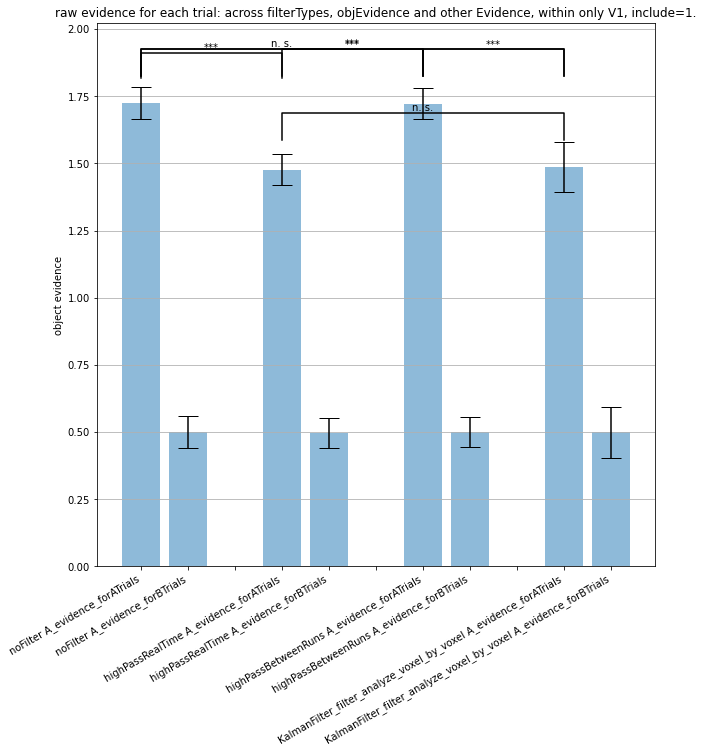

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.005254248878283173
noFilter highPassBetweenRuns p=0.37656270069454756
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.00010119902290872253
highPassRealTime highPassBetweenRuns p=0.0025984282887574024
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.019463385374922378
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.000676719111803803


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


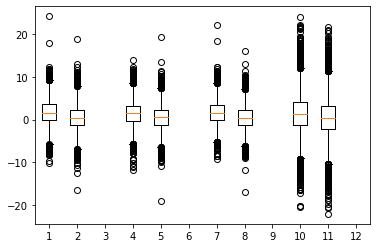

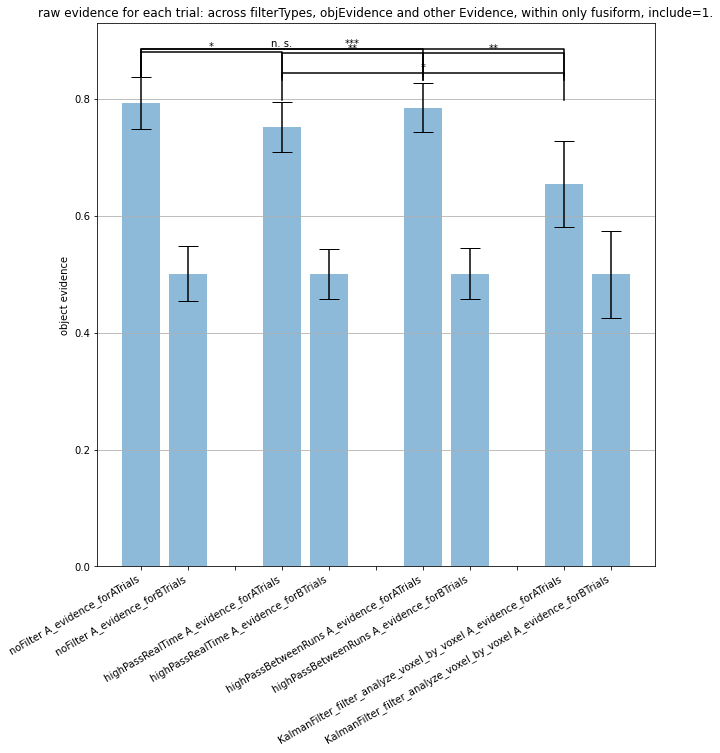

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.8875650896193614
noFilter highPassBetweenRuns p=0.26102930479221675
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.5503705147153188
highPassRealTime highPassBetweenRuns p=0.15327842788819443
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.5785117991606803
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.8189778941721567


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [ ]:
def evidenceAcrossFiltertypes(ROI="V1"):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 1440*32 numbers (say we have 32 subjects), each number is raw value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
            d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

        a.append(concatArrayArray(c))
        a.append(concatArrayArray(d))
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a=',[len(i) for i in a])
    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
        pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'raw evidence for each trial: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes(ROI=ROIs[i])


In [ ]:
def evidenceAcrossFiltertypes_meanForSub(ROI="V1"):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is mean value of the 'A_evidence_forATrials for noFilter' for that subject.

    # across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
    filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

    # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
            d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))

        a.append(c)
        a.append(d)
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a = ',[len(i) for i in a])

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
        pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes_meanForSub(ROI=ROIs[i])


In [ ]:
def accuracyAcrossFiltertype(ROI="V1"):
    # accuracy: across filterType, take subject mean, within only V1, include=1.

    # I want to construction a list whose 1st element is the accuracy for noFilter, 2nd for highpass and so on.
    # each element is 32 numbers for 32 subjects. each number is the mean accuracy for that subject.
    a=[]
    for i in range(len(filterTypes)):
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterTypes[i],
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==1.
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    # bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.')
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # # paired ttest
    # objects=np.arange(4)
    # allpairs = itertools.combinations(objects,2)
    # for pair in allpairs:
    #     i=pair[0]
    #     j=pair[1]
    #     print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")


    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")
        pvalue[(i,j)]=stats.ttest_rel(a[i],a[j])[1]
        pairs.append((i,j))
    bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)
    # bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

for i in range(len(ROIs)):
    accuracyAcrossFiltertype(ROI=ROIs[i])